In [0]:
import geopy
import pandas as pd
import numpy as np
import json, random, math
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D 
from shapely.geometry.polygon import LinearRing, Polygon
from celluloid import Camera
from IPython.display import HTML
# guide - https://hackmd.io/@nomemm/Sy9f3N7-8

from functools import lru_cache
plt.ioff()

In [0]:
!wget https://raw.githubusercontent.com/hflabs/city/master/city.csv -O city.csv
!wget https://www.dropbox.com/s/sadvwkzbqjjurdv/russia.json?dl=1 -O country_outline.json
!pip install celluloid
from google.colab import output
output.clear()

In [0]:
NUM_OF_CITIES = 30
with open('country_outline.json') as f:
    geojson = json.load(f)
rus_data = geojson[0]['geojson']['coordinates'][4:]

In [0]:
cit = pd.read_csv('city.csv')
cit = cit[['address','geo_lat', 'geo_lon', 'population']]
dropix = cit[cit['population'].str.contains(pat = ']')].index
cit = cit.drop(dropix)
cit[['geo_lat', 'geo_lon', 'population']] = cit[['geo_lat', 'geo_lon', 'population']].apply(pd.to_numeric)
cit = cit.sort_values('population',ascending=False)
cit['address'] = cit['address'].apply(lambda x: x.split()[-1])
df = cit[:NUM_OF_CITIES]
df.columns = ['name', 'lat', 'lon', 'pop']
df = df.reset_index(drop = True)
cits = list(df.itertuples())

In [35]:
from geopy import distance
distance.distance((cits[0].lat, cits[0].lon), (cits[1].lat, cits[1].lon)).km
# dist from MSK to SPb. Sort of correct.

636.023102484926

In [0]:
@lru_cache(maxsize = 1024)
def get_dist(idx1, idx2):
  cit1, cit2 = cits[idx1], cits[idx2]
  return distance.great_circle((cit1.lat, cit1.lon), (cit2.lat, cit2.lon)).km

In [0]:
def path_dist(path):
  res = 0
  for i in range(len(path)-1):
    res += get_dist(path[i].Index, path[i+1].Index)
  return res + get_dist(path[0].Index, path[-1].Index)

def transition_energy(new_, old_, T):
  return math.exp((old_-new_)/(T))


def energy_len(path, T):
  l = path_dist(path)
  return np.exp(-l/T), l

def random_swap(path_):
  a,b = random.sample(range(len(path_)),2)
  path = path_.copy()
  path[a], path[b] = path[b], path[a]
  return path

In [0]:
def draw_outline(ax, rus_data):
    for i in rus_data:
        ring = LinearRing(i[0])
        x, y = ring.xy
        ax.plot(x, y, color='#ff0000', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def draw_cities(ax, cits):
    for c in cits:
        x = c.lon
        y = c.lat
        lab = c.name
        ax.plot()
        ax.plot(x,y,'bo')
        ax.text(x * (1 + 0.001), y * (1 + 0.001) , lab, fontsize=8)

def draw_path(ax, path, curlen, i, t):
    x, y = list(zip(*map(lambda x: (x.lon, x.lat), path)))
    ax.add_line(Line2D(x, y))
    ax.text(0.5, 1.01, f'Iteration {i}: current_length = {curlen}, T = {t}', transform=ax.transAxes)

def init_canvas():
    fig = plt.figure(figsize=[12,6])
    ax = fig.add_subplot(111)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    ax.set_xlim(25, 150)
    ax.set_ylim(40, 80)
    return fig, ax

Initial path length for T = 50000.0 is 59261.96698388466
Iteration #0: current length = 59261.96698388466
Iteration #1: current length = 59134.02905600187
Iteration #2: current length = 59134.02905600187
Iteration #3: current length = 59134.02905600187
Iteration #4: current length = 59134.02905600187
Iteration #5: current length = 58655.40552635273
Iteration #6: current length = 58655.40552635273
Iteration #7: current length = 56500.477901150254
Iteration #8: current length = 56173.19715264252
Iteration #9: current length = 56173.19715264252
Iteration #10: current length = 56173.19715264252
Iteration #11: current length = 56173.19715264252
Iteration #12: current length = 49673.12310964766
Iteration #13: current length = 49404.080255989065
Iteration #14: current length = 49404.080255989065
Iteration #15: current length = 49404.080255989065
Iteration #16: current length = 49404.080255989065
Iteration #17: current length = 49134.704305233965
Iteration #18: current length = 49134.704305233

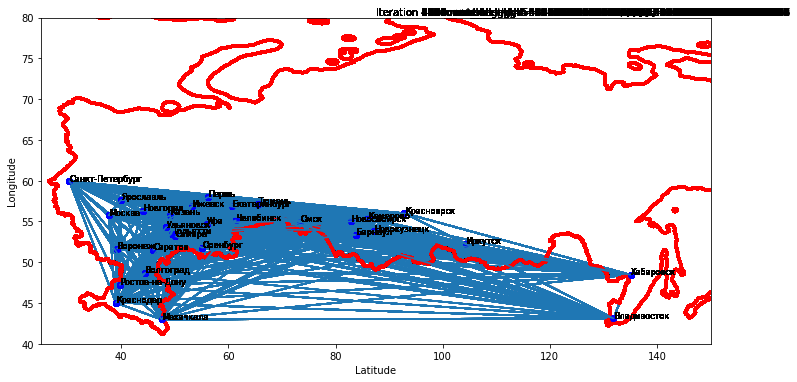

In [39]:
np.random.seed(2)
random.seed(2)
path = cits.copy()
random.shuffle(path)
anneal_rate = 0.999
T = 50000.0
anneal_every = 1
max_iter = 2000
cur_energy, cur_len = energy_len(path, T)
best_len, best_path = cur_len, path
fig, ax = init_canvas()
camera = Camera(fig)

print(f'Initial path length for T = {T} is', cur_len)

for iteration in range(max_iter):
  if T < 3:
    print("T decay stopping, T =",T)
    break
  proposal = random_swap(path)
  prop_energy, prop_len = energy_len(proposal, T)
  try:
    tr_eng = transition_energy(prop_len, cur_len, T)
  except OverflowError:
    print('Error rounded to zero! Breaking...')
    break
  if prop_len <= cur_len or  tr_eng <= np.random.uniform():
    cur_len = prop_len
    cur_energy = prop_energy
    path = proposal
    draw_outline(ax, rus_data)
    draw_cities(ax, cits)
    draw_path(ax, path, cur_len, iteration, T)
    camera.snap()
    if cur_len <= best_len:
      best_len = cur_len
      best_path = path
  if not iteration % anneal_every:
    T *= anneal_rate
    print(f'Iteration #{iteration}: current length = {cur_len}')
print("Iterations =",iteration)
print(f'Best path with len = {best_len}')

In [40]:
HTML(camera.animate(interval = 50, repeat_delay = 10000).to_html5_video())

In [0]:
animation = camera.animate(interval = 50, repeat_delay = 10000)
animation.save('animation.mp4')